In [1]:
import os 
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
from PIL import Image
import math

/home/user/miniconda3/envs/yezey/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## read clean labels
root = '../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/labels'
boxes = {}
for name in os.listdir(root):
    # with open(root+'/'+name) as file:
    #     lines = file.readlines()
    # for line in lines:
    #     cls, x_c, y_c, w, h    = map(float,line.strip().split(' '))
    #     # xmin, ymin, xmax, ymax     = int(xmin), int(ymin), int(xmax), int(ymax)
    #     boxes.append([x_c, y_c, w, h, name, cls])
    boxes[name] = []
    with open(root+'/'+name, 'r') as f:
        for box in f.readlines():
            box = box.strip('\n').split(' ')
            cls = int(box[0])
            x1,y1,w,h = [float(n) for n in box[1:]]
            boxes[name].append([cls,x1,y1,w,h])

# root_noise = '/data1/YiZhenyu/Project/polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/noise_box_labels/normal_0.1'
# noise_boxes = {}
# for name in os.listdir(root_noise):
#     # with open(root+'/'+name) as file:
#     #     lines = file.readlines()
#     # for line in lines:
#     #     cls, x_c, y_c, w, h    = map(float,line.strip().split(' '))
#     #     # xmin, ymin, xmax, ymax     = int(xmin), int(ymin), int(xmax), int(ymax)
#     #     boxes.append([x_c, y_c, w, h, name, cls])
#     noise_boxes[name] = []
#     with open(root_noise+'/'+name, 'r') as f:
#         for box in f.readlines():
#             box = box.strip('\n').split(' ')
#             cls = int(box[0])
#             x1,y1,w,h = [float(n) for n in box[1:]]
#             noise_boxes[name].append([cls,x1,y1,w,h])

正态分布

In [10]:
ratio_offset_c = 0.4 # 0.2
mean_c, sigma_c = 0, ratio_offset_c/3

factor_center = np.random.normal(mean_c,sigma_c,size=(len(boxes),2))  # [len-boxes,2]

ratio_offset = 0.4 # 0.2
mean, sigma = 0.1, ratio_offset/3
factor_w = np.random.normal(mean,sigma,size=len(boxes))
factor_h = np.random.normal(mean,sigma,size=len(boxes))

# factor = factor[(factor>0.8) * (factor<1.2)]

# sns.distplot(ratio, hist=False)
# sns.displot(factorx)
# plt.scatter(factor_center[:,0],factor_center[:,1])

In [15]:
factor_center_save = factor_center
factor_w_save = factor_w 
factor_h_save = factor_h

均匀分布

In [5]:
ratio_offset = 0.1
factor_xc = np.random.uniform(low=-ratio_offset, high=ratio_offset, size=len(boxes))
factor_yc = np.random.uniform(low=-ratio_offset, high=ratio_offset, size=len(boxes))
factor_w = np.random.uniform(low=-ratio_offset, high=ratio_offset, size=len(boxes))
factor_h = np.random.uniform(low=-ratio_offset, high=ratio_offset, size=len(boxes))

Generate

In [4]:
'''generate function'''
def get_noise_axes(box,factor_center,factorh,factorw):
    x_c, y_c = box[0]*factor_center[0], box[1]*factor_center[1]
    w, h     = box[2]*factorw, box[3]*factorh

    # 防止超出图片大小
    x_c = x_c if (x_c-w/2) >=0 else w/2
    y_c = y_c if (y_c-h/2) >=0 else h/2
    w = w if (x_c+w/2) <=1 else (1-x_c)*2
    h = h if (y_c+h/2) <=1 else (1-y_c)*2
    return [x_c, y_c, w, h]

# 正态噪声
def get_noise_axes_normal(name,box,H,W,factor_center,factor_w,factor_h):
    x_c, y_c= box[0]*W, box[1]*H
    w, h     = box[2]*W, box[3]*H
    r = np.sqrt(w**2+h**2)
    
    factor_xc,factor_yc = factor_center
    # noisy_cx = x_c + factor_xc*r
    # noisy_cy = y_c + factor_yc*r
    noisy_cx = x_c + factor_xc*w
    noisy_cy = y_c + factor_yc*h
    
    noisy_w = w + factor_w*w
    noisy_h = h + factor_h*h

    # 防止超出图片大小

    noisy_x1, noisy_y1 = max(0, noisy_cx - noisy_w/2), max(0, noisy_cy - noisy_h/2),
    noisy_x2, noisy_y2 = min(noisy_cx + noisy_w/2, W - 1), min(noisy_cy + noisy_h/2, H-1)

    # if name =='cju2rkjfwoxys0993x768l1j2.txt':
    #     print(noisy_x1,noisy_x2)
    #     print(noisy_y1,noisy_y2)

    if noisy_x2 <= noisy_x1 or noisy_y2 <= noisy_y1:
        return box
    else:
        return [(noisy_x2+noisy_x1)/2/W,(noisy_y2+noisy_y1)/2/H,(noisy_x2-noisy_x1)/W,(noisy_y2-noisy_y1)/H]


# 均匀噪声
def get_noise_axes_uniform(name,box,H,W,factor_xc,factor_yc,factor_w,factor_h):
    x_c, y_c= box[0]*W, box[1]*H
    w, h     = box[2]*W, box[3]*H

    noisy_cx = x_c + factor_xc*w
    noisy_cy = y_c + factor_yc*h
    noisy_w = w + factor_w*w
    noisy_h = h + factor_h*h

    # 防止超出图片大小

    noisy_x1, noisy_y1 = max(0, noisy_cx - noisy_w/2), max(0, noisy_cy - noisy_h/2),
    noisy_x2, noisy_y2 = min(noisy_cx + noisy_w/2, W - 1), min(noisy_cy + noisy_h/2, H-1)

    # if name =='cju2rkjfwoxys0993x768l1j2.txt':
    #     print(noisy_x1,noisy_x2)
    #     print(noisy_y1,noisy_y2)

    if noisy_x2 <= noisy_x1 or noisy_y2 <= noisy_y1:
        return box
    else:
        return [(noisy_x2+noisy_x1)/2/W,(noisy_y2+noisy_y1)/2/H,(noisy_x2-noisy_x1)/W,(noisy_y2-noisy_y1)/H]

In [5]:
'''cof_calculate and show'''
def dice_iou_coefficient(x, target):
    # print(x.shape,target.shape)
    eps = 1e-5
    # n_inst = x.size(0)
    # x = x.reshape(n_inst, -1)
    # target = target.reshape(n_inst, -1)
    intersection = (x * target).sum()
    union = (x ** 2.0).sum() + (target ** 2.0).sum() + eps
    dice = 2 * intersection / union
    iou =  intersection/(union - intersection)
    return dice,iou

def diceANDiou(boxes,noise_boxes,root_img):
    dice = 0.0
    iou = 0.0
    for name in boxes.keys():
        img_path = root_img+'/'+name[:-4] + '.png'
        img = cv2.imread(img_path)
        h, w = img.shape[:-1]
        boxes0 = boxes[name]
        noise_boxes0 = noise_boxes[name]
        box_mask = np.zeros((h,w))
        noise_box_mask = np.zeros((h,w))
        
        for i in range(len(boxes0)):
            box = boxes0[i][1:]
            xmin = int((box[0]-box[2]/2)*w)
            xmax = int((box[0]+box[2]/2)*w)
            ymin = int((box[1]-box[3]/2)*h)
            ymax = int((box[1]+box[3]/2)*h)
            box_mask[ymin:ymax,xmin:xmax] = 1

            box = noise_boxes0[i][1:]
            xmin = int((box[0]-box[2]/2)*w)
            xmax = int((box[0]+box[2]/2)*w)
            ymin = int((box[1]-box[3]/2)*h)
            ymax = int((box[1]+box[3]/2)*h)
            noise_box_mask[ymin:ymax,xmin:xmax] = 1
        
        dice_img, iou_img = dice_iou_coefficient(noise_box_mask,box_mask)
        dice+=dice_img
        iou+=iou_img
    return dice/len(boxes),iou/len(boxes)

In [6]:
def fp16_clamp(x, min=None, max=None):
    if not x.is_cuda and x.dtype == torch.float16:
        # clamp for cpu float16, tensor fp16 has no clamp implementation
        return x.float().clamp(min, max).half()

    return x.clamp(min, max)

def dice_iou_coefficient_boxlevel(bboxes1, bboxes2,eps=1e-6):
    # x:[N,4], 4:[x0,y0,x1,y1]
    # target:[N,4].
    assert (bboxes1.shape[-1] == 4 or bboxes1.shape[0] == 0)
    assert (bboxes2.shape[-1]  == 4 or bboxes2.shape[0]  == 0)
    assert bboxes1.shape[:-2] == bboxes2.shape[:-2]
    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (
        bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (
        bboxes2[..., 3] - bboxes2[..., 1])
    
    lt = torch.max(bboxes1[..., :2], bboxes2[..., :2])  # [B, rows, 2]
    rb = torch.min(bboxes1[..., 2:], bboxes2[..., 2:])  # [B, rows, 2]

    wh = fp16_clamp(rb - lt, min=0)
    overlap = wh[..., 0] * wh[..., 1]
    union = area1 + area2 - overlap
    eps = union.new_tensor([eps])
    union = torch.max(union, eps)
    iou = overlap / union
    dice = 2*overlap / (area1+area2)

    return dice.float().mean(), iou.float().mean()


def diceANDiou_boxlevel(boxes,noise_boxes,root_img):
    dice = 0.
    iou = 0.
    for name in boxes.keys():
        img_path = root_img+'/'+name[:-4] + '.png'
        img = cv2.imread(img_path)
        h, w = img.shape[:-1]
        boxes0 = boxes[name]
        noise_boxes0 = noise_boxes[name]
        boxes00 = []
        noise_boxes00 = []
        for i in range(len(boxes0)):
            box = boxes0[i][1:]
            xmin = (box[0]-box[2]/2)*w
            xmax = (box[0]+box[2]/2)*w
            ymin = (box[1]-box[3]/2)*h
            ymax = (box[1]+box[3]/2)*h
            boxes00.append([xmin,ymin,xmax,ymax])

            box = noise_boxes0[i]
            xmin = (box[0]-box[2]/2)*w
            xmax = (box[0]+box[2]/2)*w
            ymin = (box[1]-box[3]/2)*h
            ymax = (box[1]+box[3]/2)*h
            noise_boxes00.append([xmin,ymin,xmax,ymax])
        dice_img, iou_img = dice_iou_coefficient_boxlevel(torch.tensor(noise_boxes00),torch.tensor(boxes00))
        dice+=dice_img
        iou+=iou_img
        
    return dice/len(boxes),iou/len(boxes)




In [7]:

def show(boxes,noise_boxes,noise_boxes222=None):    
    root_noise='../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/noise_box_labels/normal_0.2/' 
    key = random.choice(list(boxes.keys()))


    img_path = root.replace('labels','images')+'/'+key.replace('txt','png')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y_img, x_img = img.shape[:-1]

    noise_box_path = root_noise+'/'+key

    ## 
    box_mask = np.zeros((y_img,x_img), dtype=np.uint8)
    box = boxes[key]
    for i in range(len(box)):
        _,x_c,y_c,w,h = box[i]
        x1, x2 = int((x_c-w/2)*x_img), int((x_c+w/2)*x_img)
        y1, y2 = int((y_c-h/2)*y_img), int((y_c+h/2)*y_img)

        box_mask[y1:y2,x1:x2] = 1
    contours, _ = cv2.findContours(box_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)

    ##
    box_mask = np.zeros((y_img,x_img), dtype=np.uint8)
    box = noise_boxes[key]
    for i in range(len(box)):
        x_c,y_c,w,h = box[i]
        x3, x4 = int((x_c-w/2)*x_img), int((x_c+w/2)*x_img)
        y3, y4 = int((y_c-h/2)*y_img), int((y_c+h/2)*y_img)

        box_mask[y3:y4,x3:x4] = 1
    contours, _ = cv2.findContours(box_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img, contours, -1, (0, 0, 255), 1)
    
    if noise_boxes222 is not None:
        box_mask = np.zeros((y_img,x_img), dtype=np.uint8)
        box = noise_boxes222[key]
        for i in range(len(box)):
            x_c,y_c,w,h = box[i]
            x3, x4 = int((x_c-w/2)*x_img), int((x_c+w/2)*x_img)
            y3, y4 = int((y_c-h/2)*y_img), int((y_c+h/2)*y_img)

            box_mask[y3:y4,x3:x4] = 1
        contours, _ = cv2.findContours(box_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
    
    plt.imshow(img)
    print('box:',(x1,y1,x2,y2),'noise_box:',(x3,y3,x4,y4))

In [17]:
## generate nosie-boxes
noise_boxes = {}
# root_noise='../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/noise_box_labels/normal_0.2/' 

for j,name in enumerate(boxes):
    box = boxes[name]
    img_path = root.replace('labels','images')+'/'+name[:-4] + '.png'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y_img, x_img = img.shape[:-1]
    noise_boxes[name] = []
    for i in range(len(box)):  
        axes = box[i][1:]
        # noise_axes = get_noise_axes(axes,factor_center[j],factorh[j],factorw[j])
        noise_axes = get_noise_axes_normal(name,axes,y_img,x_img,factor_center[j],factor_w[j],factor_h[j])
        noise_boxes[name].append(noise_axes)

    # with open(root_noise+name,'a') as f:
    #     for i in range(len(box)):
    #         cls = box[i][0]
    #         f.write(str(int(cls)))
    #         axes = box[i][1:]
    #         # noise_axes = get_noise_axes(axes,factor_center[j],factorh[j],factorw[j])
            
    #         noise_axes = get_noise_axes_normal(name,axes,y_img,x_img,factor_center[j],factor_w[j],factor_h[j])
    #         for ax in noise_axes:
    #             f.write(' '+ str(ax))
    #         f.write('\n')


In [18]:
## dice and iou
root_img='../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/images' 
cof = diceANDiou_boxlevel(boxes,noise_boxes,root_img)
print('dice and iou:',cof)

dice and iou: (tensor(0.9059), tensor(0.8289))


In [11]:
## save
root_noise='../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/noise_box_labels/normal_0.4_new/' 
os.makedirs(root_noise,exist_ok=True)
for j,name in enumerate(boxes):
    box = boxes[name]
   
    # noise_axes = noise_boxes[name]
    img_path = root.replace('labels','images')+'/'+name[:-4] + '.png'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y_img, x_img = img.shape[:-1]    
    with open(root_noise+name,'a') as f:
        for i in range(len(box)):
            cls = box[i][0]
            f.write(str(int(cls)))
            axes = box[i][1:]
            noise_axes = get_noise_axes_normal(name,axes,y_img,x_img,factor_center[j],factor_w[j],factor_h[j])
            
            
            for ax in noise_axes:
                f.write(' '+ str(ax))
            f.write('\n')

box: (313, 94, 504, 316) noise_box: (309, 94, 505, 343)


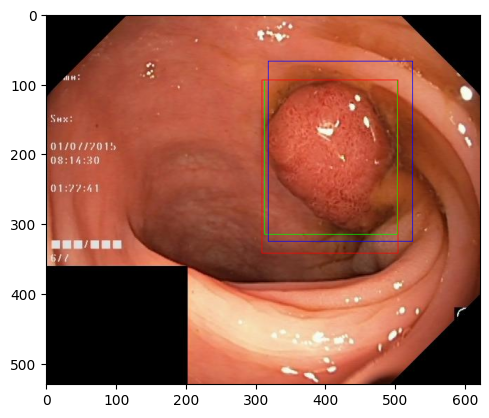

In [53]:
show(boxes,noise_boxes)

calulate the dice of the existed dataset

In [13]:
root_noise = '/data1/YiZhenyu/Project/polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/noise_box_labels/normal_0.3_new'
noise_boxes222 = {}
for name in os.listdir(root_noise):
    # with open(root+'/'+name) as file:
    #     lines = file.readlines()
    # for line in lines:
    #     cls, x_c, y_c, w, h    = map(float,line.strip().split(' '))
    #     # xmin, ymin, xmax, ymax     = int(xmin), int(ymin), int(xmax), int(ymax)
    #     boxes.append([x_c, y_c, w, h, name, cls])
    noise_boxes222[name] = []
    with open(root_noise+'/'+name, 'r') as f:
        for box in f.readlines():
            box = box.strip('\n').split(' ')
            cls = int(box[0])
            x1,y1,w,h = [float(n) for n in box[1:]]
            noise_boxes222[name].append([x1,y1,w,h])
root_img='../../polyp-segmentation/Polyp-PVT/dataset/TrainDataset/CVC550_Kvasir900/images' 
cof = diceANDiou_boxlevel(boxes,noise_boxes222,root_img)
print('dice and iou:',cof)

dice and iou: (tensor(0.8314), tensor(0.7173))
